# MESQUAL 305: HTML Dashboard Utility
This notebook demonstrates how to use the HTMLDashboard utility to combine multiple visualizations into a single HTML file for easy sharing and viewing.

## Introduction
When working with multiple visualizations (Plotly figures, Folium maps, etc.), it can be cumbersome to have separate HTML files for each one. The HTMLDashboard utility provides a simple way to combine multiple visualizations into a single, well-structured HTML file that can be easily shared with stakeholders or published online.

## Setup

First, we need to set up the environment. If you are on Colab, the first cell will clone and install all dependencies. You will have to restart the session afterwards and continue with cell 2. If you are in a local environment, make sure that you have followed the Getting started steps in the README, so that mesqual and all requirements are installed.

In [1]:
import os

if "COLAB_RELEASE_TAG" in os.environ:
    import importlib.util

    def is_module_available(module_name):
        return importlib.util.find_spec(module_name) is not None

    if os.path.exists("mesqual-vanilla-studies") and is_module_available("mesqual"):
        print("✅ Environment already set up. Skipping installation.")
    else:
        print("🔧 Setting up Colab environment...")
        !git clone --recursive https://github.com/helgeesch/mesqual-vanilla-studies.git
        %cd mesqual-vanilla-studies/

        !pip install git+https://github.com/helgeesch/mesqual -U
        !pip install git+https://github.com/helgeesch/mesqual-pypsa -U
        !pip install git+https://github.com/helgeesch/captain-arro -U
        !pip install -r requirements.txt

        print('✅ Setup complete. 🔁 Restart the session, then skip this cell and continue with the next one.')
else:
    print("🖥️ Running locally. No setup needed.")

Running locally, let's continue.


In [2]:
import os

if "COLAB_RELEASE_TAG" in os.environ:
    import sys
    sys.path.append('/content/mesqual-vanilla-studies')
    os.chdir('/content/mesqual-vanilla-studies')
else:
    def setup_notebook_env():
        """Set working directory to repo root and ensure it's in sys.path."""
        import os
        import sys
        from pathlib import Path

        def find_repo_root(start_path: Path) -> Path:
            current = start_path.resolve()
            while current != current.parent:
                if (current / 'vanilla').exists():
                    return current
                current = current.parent
            raise FileNotFoundError(f"Repository root not found from: {start_path}")

        repo_root = find_repo_root(Path.cwd())
        os.chdir(repo_root)
        if str(repo_root) not in sys.path:
            sys.path.insert(0, str(repo_root))

    setup_notebook_env()

try:
    from mesqual import StudyManager
except ImportError:
    raise ImportError("❌ 'mesqual' not found. If you're running locally, make sure you've installed all dependencies as described in the README.")

if not os.path.isdir("studies"):
    raise RuntimeError(f"❌ 'studies' folder not found. Make sure your working directory is set to the mesqual-vanilla-studies root. Current working directory: {os.getcwd()}")

print("✅ Environment ready. Let’s go!")

✅ Environment ready. Let’s go!


In [3]:
import os
import plotly.express as px
import folium

from mesqual.visualizations.html_dashboard import HTMLDashboard
from mesqual.utils.folium_utils import MapCountryPlotter
from mesqual.utils.plotly_utils.plotly_theme import PlotlyTheme
from vanilla.notebook_config import configure_clean_output_for_jupyter_notebook
from vanilla.conditional_renderer import ConditionalRenderer

configure_clean_output_for_jupyter_notebook()
PlotlyTheme().apply()
renderer = ConditionalRenderer()

## Creating Plotly Visualizations
Let's create some sample Plotly visualizations that we'll include in our dashboard:

In [4]:
# Sample dataset
data = px.data.gapminder().query("year == 2007")

# Create first visualization: GDP vs Life Expectancy
fig1 = px.scatter(
    data, 
    x="gdpPercap", 
    y="lifeExp", 
    size="pop", 
    color="continent",
    hover_name="country", 
    log_x=True, 
    size_max=60,
    title="GDP vs Life Expectancy (2007)"
)
fig1.update_layout(height=500)

# Create second visualization: Population by Continent
fig2 = px.bar(
    data.groupby("continent")["pop"].sum().reset_index(), 
    x="continent", 
    y="pop", 
    color="continent",
    title="Population by Continent (2007)"
)
fig2.update_layout(height=500)

# Create third visualization: Life Expectancy Distribution
fig3 = px.box(
    data, 
    x="continent", 
    y="lifeExp", 
    color="continent",
    title="Life Expectancy Distribution by Continent (2007)"
)
fig3.update_layout(height=500);

## Creating a Folium Map
Next, let's create a Folium map visualization:

In [5]:
# Create a map centered in Europe
m = folium.Map(location=[50, 10], zoom_start=3)

# Initialize country plotter
plotter = MapCountryPlotter()

# Create a simple choropleth-like map with country data
countries = ["DE", "FR", "IT", "ES", "GB", "SE", "NO", "FI", "PL", "RO"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", 
          "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Create feature group
fg = folium.FeatureGroup(name="Europe")

# Add countries with different colors
for country, color in zip(countries, colors):
    plotter.add_countries_to_feature_group(
        fg,
        countries=[country],
        style={
            "fillColor": color,
            "color": "white",
            "weight": 1,
            "fillOpacity": 0.7
        }
    )

# Add to map
fg.add_to(m)

# Add background countries
background_fg = folium.FeatureGroup(name="Background")
plotter.add_all_countries_except(
    background_fg,
    excluded_countries=countries,
    style={"fillColor": "#f8f8f8", "color": "#e0e0e0", "weight": 0.5, "fillOpacity": 0.5}
)
background_fg.add_to(m)

# Add layer control
folium.LayerControl().add_to(m);

## Creating a Simple Data Table
Let's also create a simple HTML table to include in our dashboard:

In [6]:
from mesqual.visualizations.html_table import HTMLTable

table = HTMLTable(
    df=data,
    title="Gapminder Dataset (2007)",
    height="500px",
    theme="modern",
    pagination="local",
    page_size=15,
)

## Building the Dashboard
Now let's combine all our visualizations into a single HTML dashboard:

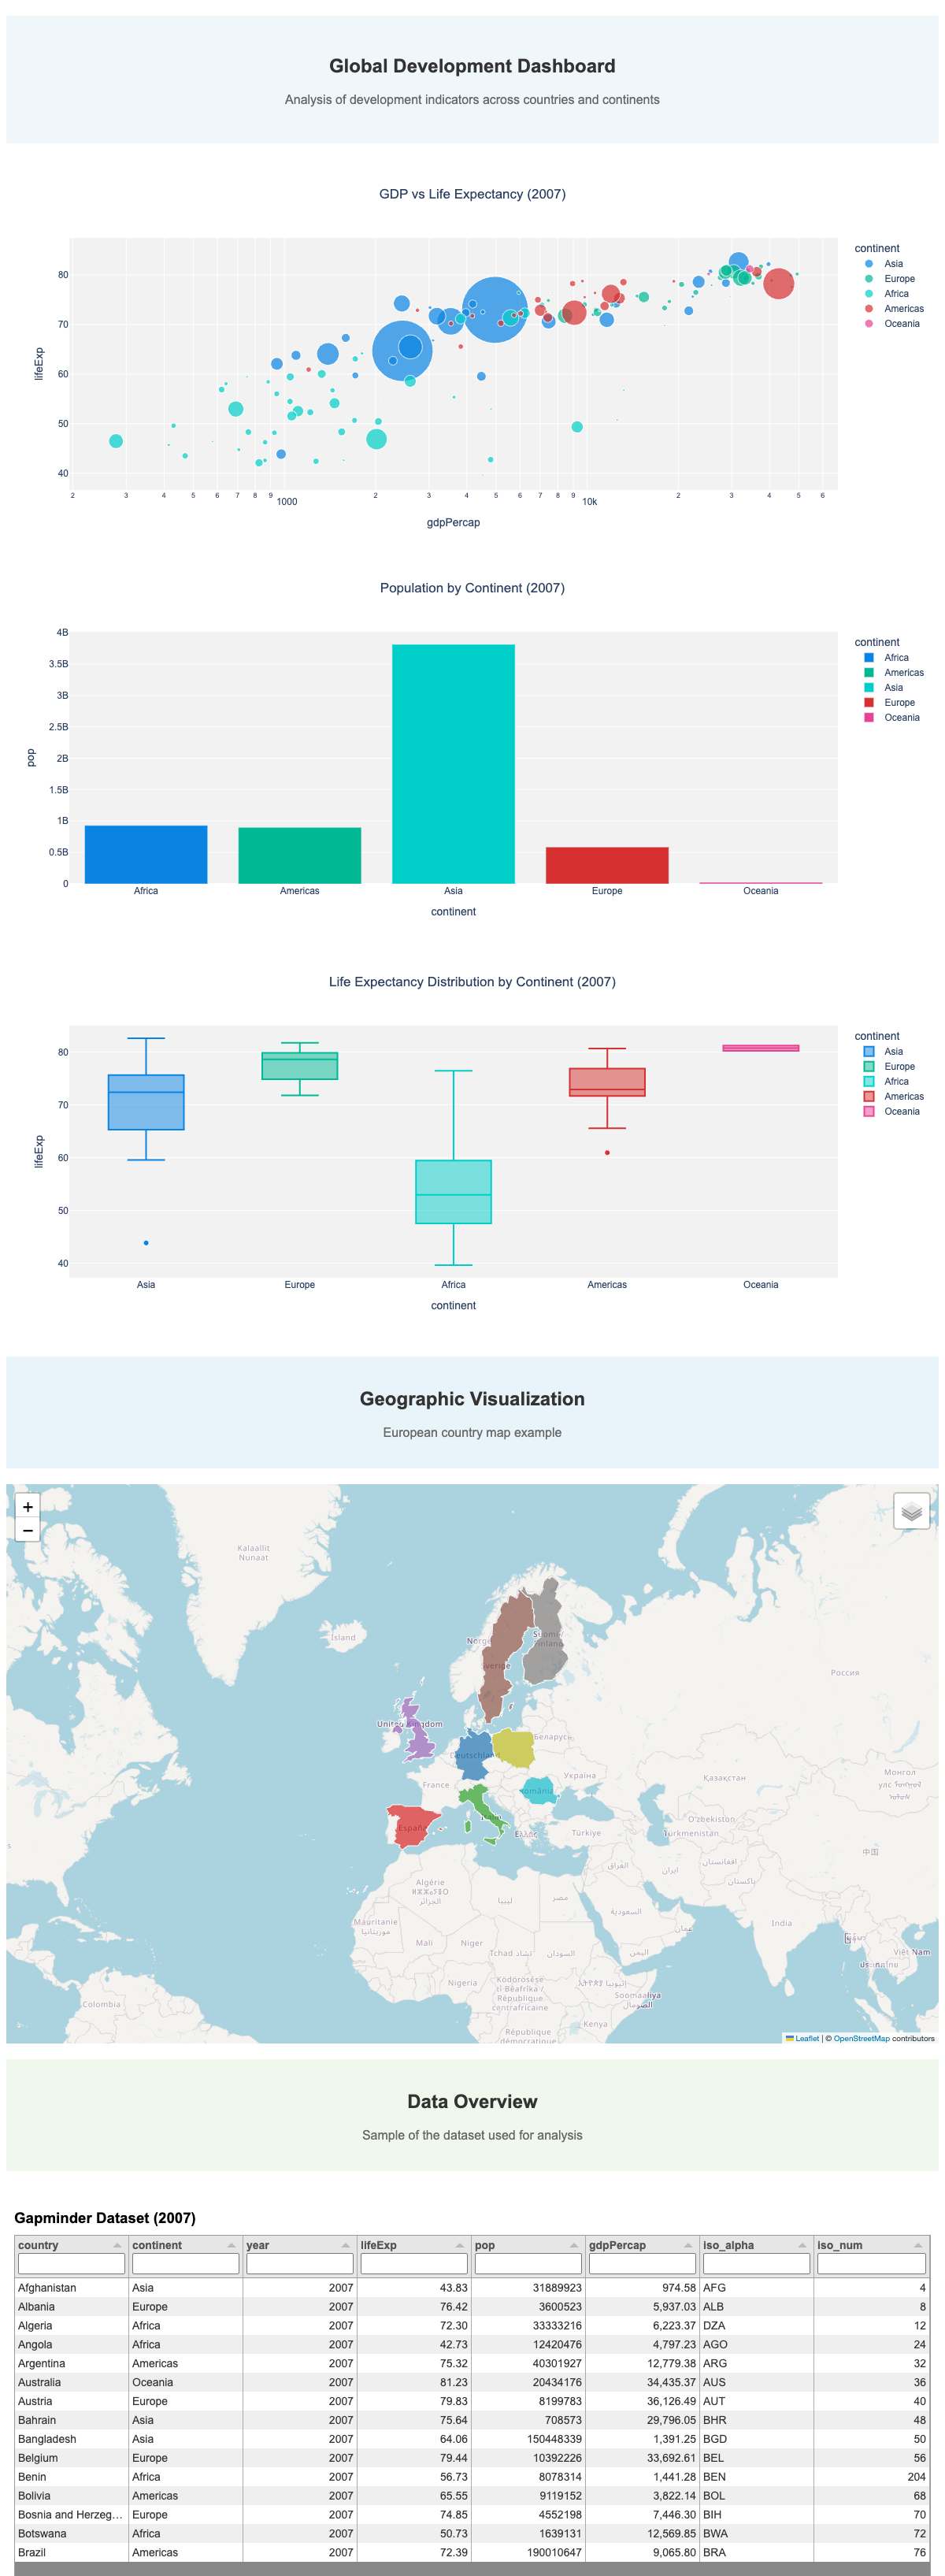

In [7]:
# Create a new dashboard
dashboard = HTMLDashboard(name="Global Development Dashboard")

# Add title section
dashboard.add_section_divider(
    title="Global Development Dashboard",
    subtitle="Analysis of development indicators across countries and continents",
    background_color="#f0f7fa",
    padding="30px",
    border_bottom="3px solid #3498db"
)

# Add plotly figures
dashboard.add_plotly_figure(fig1, height="500px", name="gdp_vs_lifeexp")
dashboard.add_plotly_figure(fig2, height="500px", name="population_by_continent")
dashboard.add_plotly_figure(fig3, height="500px", name="lifeexp_distribution")

# Add geographic section
dashboard.add_section_divider(
    title="Geographic Visualization",
    subtitle="European country map example",
    background_color="#e8f4f9"
)

# Add folium map directly using the new method
dashboard.add_folium_map(m)

# Add data section
dashboard.add_section_divider(
    title="Data Overview",
    subtitle="Sample of the dataset used for analysis",
    background_color="#f0f7ed",
    border_left="5px solid #2ecc71"
)

# Add data table
dashboard.add_table(table, name="data_table")

# Add footer
dashboard.add_section_divider(
    title="",
    subtitle="Created with MESQUAL HTMLDashboard | 2025",
    background_color="#f9f9f9",
    padding="10px",
    subtitle_color="#888",
    border_top="1px solid #ddd"
)

# Save the dashboard
# dashboard.save('your/dashboard/export/path.html')

# View dashboard
renderer.show_html_dashboard(dashboard)

## Use Cases and Best Practices

The HTMLDashboard utility is particularly useful for:

1. **Sharing Results**: Create comprehensive reports combining multiple visualizations
2. **Market Analysis**: Build dashboards showing electricity prices, flows, and generation mixes
3. **Comparative Studies**: Combine maps, charts, and tables to show scenario differences
4. **Static Reporting**: Create standalone HTML files that don't require server infrastructure

Best practices:

- **Name your elements**: Using meaningful names makes reordering easier
- **Organize content logically**: Group related visualizations together
- **Consider load time**: Many large visualizations may slow down page loading
- **Use section headers**: Divide your dashboard into clear sections with headings
- **Add context**: Include text explanations to help readers understand your visualizations

## Conclusion

The HTMLDashboard utility provides a simple yet powerful way to combine multiple visualizations into a single HTML file. This makes it easy to create comprehensive dashboards and reports that can be shared with stakeholders or published online.

By leveraging HTML, Plotly, and Folium, you can create rich, interactive visualizations that work in any modern web browser without requiring special software or server infrastructure.